# BOFdat step 1

## Generate stoichiometric coefficients for the major macromolecules of the cell and calculate maintenance cost

In [1]:
from BOFdat import step1
from BOFdat.util import update
import pandas as pd
import cobra

/home/jean-christophe/.local/lib/python2.7/site-packages/pip/_vendor/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


## Example using the *E.coli* genome-scale model *i*ML1515

The weight percentage and abundance of each molecule in the cell may vary from an organism to another and vary between growth conditions for a given organism [1,2]. BOFdat allows to incorporate macromolecular cell composition obtained from literature or new experiments to generate new stoichiometric coefficients for your model's biomass objective function (BOF). Once weight percentages are obtained, OMIC data can be incorporated to buff the coefficients and fit to experimental reality. 

### Steps

The following example will lead you through all the necessary steps for the generation of the BOF stoichiometric coefficients (BOFsc) for *E.coli* K12 MG1655 GEM *i*ML1515 [3]. 

1. Obtain the macromolecular composition of the organism

2. Obtain OMICs experimental data

3. Generate BOFsc

4. Generate NGAM and GAM

5. Update BOF (BOFdat!)


### Sources

[1]  Dennis P. Patrick and Bremmer Hans. (1974) Macromolecular composition during steady-state growth of *Escherichia coli* B/r. Journal of bacteriology


[2] Benjamin Volkmer and Matthias Heinemann. (2011) Condition-Dependent Cell Volume and Concentration of Escherichia coli to Facilitate Data Conversion for Systems Biology Modeling. PLoS One


[3] Jonathan M Monk, Colton J Lloyd, Elizabeth Brunk, Nathan Mih, Anand Sastry, Zachary King, Rikiya Takeuchi, Wataru Nomura, Zhen Zhang, Hirotada Mori, Adam M Feist and Bernhard O Palsson. (2017) *i*ML1515, a knowledgebase that computes Escherichia coli traits. Nat. Biotech.

## Obtain the macromolecular compositon of the organism

*E.coli* has been characterized thoroughly in literature. The BOFsc used in *i*AF1260 [4] are the same in *i*ML1515 [3] and were obtained from Neidhart *et. al* [5].

**Note:** The package also provides the option to include the percentage of each type of RNA molecule in the cell (ribosomal, transfer and messenger). The default values are rRNA: 0.9, tRNA 0.05 and mRNA: 0.05.

### Sources

[4] Adam M Feist, Christopher S Henry, Jennifer L Reed, Markus Krummenacker, Andrew R Joyce, Peter D Karp, Linda J Broadbelt, Vassily Hatzimanikatis and Bernhard Ø Palsson. (2007) A genome-scale metabolic reconstruction for Escherichia coli K-12 MG1655 that accounts for 1260 ORFs and thermodynamic information. Mol. Syst. Bio. 

[5] Neidhardt FC, Ingraham JL, Schaechter M (1990) Physiology of the Bacterial Cell: a Molecular Approach. Sinauer Associates: Sunderland, Mass

In [2]:
#Set parameters based on dry weight composition
dna_weight_fraction = 0.031
rna_weight_fraction = 0.205
protein_weight_fraction = 0.55
lipid_weight_fraction = 0.1
metabolite_weight_fraction = 0.1

## Inputs

### DNA
    
    - Genome sequence (FASTA DNA)
    - DNA macromolecular weight fraction 
    - Model (JSON or SBML)
    
    
### RNA 

    - Genome annotation (GenBank)
    - Transcriptomic data (2 column CSV)
    - RNA macromolecular weight fraction 
    - Model (JSON or SBML)
    
    
### Proteins

    - Genome annotation (GenBank)
    - Proteomic data (2 column CSV)
    - Protein macromolecular weight fraction
    - Model (JSON or SBML)
    
    
### Lipids

    - Lipidomic abundances (2 column CSV)
    - Lipidomic conversion to model identifiers (2 column CSV)
    - Lipid macromolecular weight fraction
    - Model (JSON or SBML)
    

### Maintenance costs

    - Growth and uptake rates on different conditions (CSV)

In [3]:
#Give the path to each file as function parameters
#Genome file in BioPython supported format (.faa, .fna) and GenBank file 
#also in BioPython supported format (.gb, .gbff)
genome = 'data/Ecoli_DNA.fna'
genbank = 'data/Ecoli_K12_MG1655.gbff'

#Omic datasets as a 2 column csv file, gene and abundance
transcriptomic = 'data/transcriptomic.csv'
proteomic = 'data/proteomic.csv'

#Lipidomic abundances and conversion to model identifier
lipidomic_abundances = 'data/lipidomic_abundances.csv'
lipidomic_conversion = 'data/lipidomic_conversion.csv'


#Growth data on different carbon sources, uptake and secretion rates
maintenance = 'data/maintenance.csv'

#The model for which the coefficients are generated
model = 'data/iML1515.json'

## Obtain OMICs experimental data

Your genome should have a GenBank annotated file. This file should be provided in a BioPython supported format (.gb, .gbff). 

Search in literature allowed to find multiple OMICs dataset for different macromolecules that can be used to generate stoichiometric coefficients [6,7,8]. The data should be converted into a 2 column csv file. 
The genome file should be provided in a standard BioPython supported format (.faa or .fna) and is used to calculate the abundance of each base in the genome.

Transcriptomic and proteomic files are 2 column csv files where the first column is the **gene identifier ** and the second column is the relative abundance of each of these genes in the cell. 

Unlike DNA, RNA and proteins that are standard amongst every known life form, the lipid and metabolites in different organisms may vary. Hence a conversion file is required. This first column of this file is the original name of the compound and the second is the target identifier that this compound should have in your model. The first column of the abundance file gives the compound identifier in the model and the second column gives the abundance of that compound in the OMIC dataset.

### Sources

[6] Sang Woo Seo, Donghyuk Kim, Haythem Latif, Edward J. O’Brien, Richard Szubin & Bernhard O. Palsson. (2014) Deciphering Fur transcriptional regulatory network highlights its complex role beyond iron metabolism in Escherichia coli. Nat. Comm. 


[7] Alexander Schmidt, Karl Kochanowski, Silke Vedelaar, Erik Ahrné, Benjamin Volkmer, Luciano Callipo, Kèvin Knoops, Manuel Bauer, Ruedi Aebersold and Matthias Heinemann. (2016) The quantitative and condition-dependent *Escherichia coli* proteome. Nat. Biotech. 


[8] Kian-Kai Cheng, Baek-Seok Lee, Takeshi Masuda, Takuro Ito, Kazutaka Ikeda, Akiyoshi Hirayama, Lingli Deng, Jiyang Dong, Kazuyuki Shimizu, Tomoyoshi Soga, Masaru Tomita, Bernhard O. Palsson and Martin Robert. (2014) Global metabolic network reorganization by adaptive mutations allows fast growth of Escherichia coli on glycerol. Nat Comm.

## Generate BOFsc for macromolecules and generate maintenance costs

BOFdat operates with a single get_coefficient function for each macromolecule used. Input the parameters determined above as function parameters. Each function outputs a dictionary of metabolite and stoichiometric coefficients. The dictionary can be used to update the BOF (Step 5).

In [4]:
dna_coefficients = step1.generate_dna_coefficients(genome,model,DNA_WEIGHT_FRACTION=dna_weight_fraction)
dna_coefficients

{<Metabolite dgtp_c at 0x7fdcbedefa50>: -0.023987227235417734,
 <Metabolite ppi_c at 0x7fdcbee83f50>: 0.10089506970390794,
 <Metabolite dttp_c at 0x7fdcbeebacd0>: -0.025157688898857517,
 <Metabolite dctp_c at 0x7fdcbeedf510>: -0.02731878216895449,
 <Metabolite datp_c at 0x7fdcbeef0150>: -0.024431371400678196}

In [5]:
rna_coefficients = step1.generate_rna_coefficients(genbank,model,transcriptomic,RNA_WEIGHT_FRACTION=rna_weight_fraction)
rna_coefficients

/home/jean-christophe/.local/lib/python2.7/site-packages/BOFdat-0.1.4-py2.7.egg/BOFdat/core/rna.py:60 UserWarning: Some identifiers not found in provided annotation


{<Metabolite ctp_c at 0x7fdcbe169350>: -0.1671601704512458,
 <Metabolite atp_c at 0x7fdcbe17a590>: -0.1556843351415502,
 <Metabolite ppi_c at 0x7fdcbe209690>: 0.6397066800549615,
 <Metabolite utp_c at 0x7fdcbe22fb50>: -0.15379576979105725,
 <Metabolite gtp_c at 0x7fdcbe2bab50>: -0.16306640467110828}

In [6]:
protein_coefficients = step1.generate_protein_coefficients(genbank,model,proteomic,PROTEIN_WEIGHT_FRACTION=protein_weight_fraction)
protein_coefficients

/home/jean-christophe/.local/lib/python2.7/site-packages/BOFdat-0.1.4-py2.7.egg/BOFdat/core/protein.py:64 UserWarning: Redundancy in dataset identifiers


{<Metabolite asn__L_c at 0x7fdcb9b53650>: -0.18757538475910354,
 <Metabolite leu__L_c at 0x7fdcb9b53750>: -0.41251515857770893,
 <Metabolite h2o_c at 0x7fdcb9e342d0>: 5.444549746608695,
 <Metabolite gly_c at 0x7fdcb9e34450>: -0.8068327457540323,
 <Metabolite trp__L_c at 0x7fdcba01a0d0>: -0.02496595423787938,
 <Metabolite lys__L_c at 0x7fdcba01a150>: -0.2743566703314616,
 <Metabolite phe__L_c at 0x7fdcba11e950>: -0.12592356497070842,
 <Metabolite ala__L_c at 0x7fdcba11e9d0>: -0.786686581012288,
 <Metabolite pro__L_c at 0x7fdcbb788810>: -0.22635269540826172,
 <Metabolite glu__L_c at 0x7fdcbb8bb610>: -0.3088742159475492,
 <Metabolite ile__L_c at 0x7fdcbb8bb6d0>: -0.2907964681752002,
 <Metabolite gln__L_c at 0x7fdcbb8bbc90>: -0.16176662571366865,
 <Metabolite val__L_c at 0x7fdcbbe35dd0>: -0.44694238390821955,
 <Metabolite his__L_c at 0x7fdcbc174790>: -0.07909538580101926,
 <Metabolite ser__L_c at 0x7fdcbd2f40d0>: -0.30382792752346605,
 <Metabolite arg__L_c at 0x7fdcbd326f50>: -0.1804871043

In [7]:
lipid_coefficients = step1.generate_lipid_coefficients(lipidomic_abundances,lipidomic_conversion,model,LIPID_WEIGHT_FRACTION=lipid_weight_fraction)
lipid_coefficients

/home/jean-christophe/.local/lib/python2.7/site-packages/BOFdat-0.1.4-py2.7.egg/BOFdat/core/lipid.py:76 UserWarning: Redundancy in dataset identifiers


{<Metabolite pg160_p at 0x7fdcb9d161d0>: -0.014826578855136979,
 <Metabolite pe181_p at 0x7fdcb9d16e10>: -0.013250952451946145,
 <Metabolite pe161_p at 0x7fdcbb738c10>: -0.030710743257354293,
 <Metabolite pe160_p at 0x7fdcbb9e8610>: -0.05984233670391253,
 <Metabolite pg181_p at 0x7fdcbbc02110>: -0.009098089940190764,
 <Metabolite pg161_p at 0x7fdcbbe41690>: -0.013732749319021109}

## Generate GAM and NGAM

Growth-associated maintenance (GAM) is the ATP cost related to growth. This includes the polymerization cost of each macromolecule. This cost is unaccounted for in the BOF because the model synthesizes the building blocks of each macromolecule in sufficient quantity to reflect the cell composition but not the cost of assembling those building blocks together. The GAM can be calculated experimentally by growing the bacteria on different sources of carbon at different starting concentrations. The carbon source should be the sole source of carbon in the media and its concentration should be measured after a given time. These remaining concentrations along with the excretion products are used by the package to constrain the model and calculate the ATP cost of growth. 


cobra/util/solver.py:408 UserWarning: solver status is 'infeasible'


('m', 89.08201514974289, 'b', 12.643976801582395)
('R2=', 0.6714793285124122)


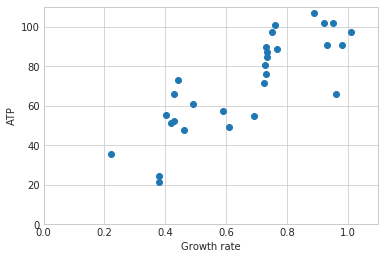

In [8]:
maintenance_cost = step1.generate_maintenance_costs(maintenance,model)

## Update BOF (BOFdat!)

All the dictionaries have been generated. Now it would be fun to start playing with the model. Actually BOFdat allows you to use the generated dictionaries to update and buff your BOF experimental data. Just buff that!

In [9]:
json_model = cobra.io.load_json_model(model)
bofdat_step1 = update.make_new_BOF(json_model,False,True,dna_coefficients,rna_coefficients,protein_coefficients,
                    lipid_coefficients,maintenance=maintenance_cost)

In [10]:
#Save the step1 objective function for use in step2
bofdat_step1.to_csv('data/bofdat_step1.csv')

**That's it!**

The BOFsc for the major macromolecules and the maintenance cost of the cell have been updated in your model using BOFdat. 